In [1]:
!pip install efficientnet
!pip install lime
!pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.8 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
import efficientnet.tfkeras as efn
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [3]:
train_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
valid_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
test_dir = '/kaggle/input/new-plant-diseases-dataset/test/test'

In [4]:
# Desired classes
desired_plants = ['Apple', 'Corn', 'Grape', 'Potato', 'Tomato']

# Collecting file paths and labels (with .DS_Store handling)
def collect_data(directory):
    filenames = []
    labels = []
    folds = os.listdir(directory)
    for fold in folds:
        if fold.startswith('.'):
            continue
        fold_path = os.path.join(directory, fold)
        if os.path.isdir(fold_path):
            files = os.listdir(fold_path)
            for file in files:
                if file.startswith('.'):
                    continue
                filepath = os.path.join(fold_path, file)
                filenames.append(filepath)
                labels.append(fold)
    return filenames, labels

filenames_train, label_train = collect_data(train_dir)
filenames_valid, label_valid = collect_data(valid_dir)

In [5]:
# DataFrames
df_train = pd.DataFrame({'filename': filenames_train, 'label': label_train})
df_valid = pd.DataFrame({'filename': filenames_valid, 'label': label_valid})

# Filter DataFrames for desired classes
df_train = df_train[df_train['label'].apply(lambda x: any(plant in x for plant in desired_plants))]
df_valid = df_valid[df_valid['label'].apply(lambda x: any(plant in x for plant in desired_plants))]


In [6]:
# Create ImageDataGenerator instances
img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col="filename",
    y_col="label",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical"
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=df_valid,
    x_col="filename",
    y_col="label",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False # Very important for evaluation.
)


Found 46356 validated image filenames belonging to 25 classes.
Found 11588 validated image filenames belonging to 25 classes.


In [7]:
# Build and train your model
num_classes = len(train_generator.class_indices)
base_model = efn.EfficientNetB3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('plant_disease_model.keras', save_best_only=True)

epochs = 50
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=valid_generator,
    callbacks=[early_stopping, model_checkpoint]
)

44107200/44107200 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1449/1449 ━━━━━━━━━━━━━━━━━━━━ 410s 261ms/step - accuracy: 0.7198 - loss: 0.8937 - val_accuracy: 0.9155 - val_loss: 0.2428
Epoch 2/50
1449/1449 ━━━━━━━━━━━━━━━━━━━━ 134s 92ms/step - accuracy: 0.8685 - loss: 0.3867 - val_accuracy: 0.9369 - val_loss: 0.1865
Epoch 3/50
1449/1449 ━━━━━━━━━━━━━━━━━━━━ 130s 89ms/step - accuracy: 0.8827 - loss: 0.3412 - val_accuracy: 0.9298 - val_loss: 0.2035
Epoch 4/50
1449/1449 ━━━━━━━━━━━━━━━━━━━━ 128s 88ms/step - accuracy: 0.8941 - loss: 0.3110 - val_accuracy: 0.9411 - val_loss: 0.1648
Epoch 5/50
1449/1449 ━━━━━━━━━━━━━━━━━━━━ 126s 87ms/step - accuracy: 0.9004 - loss: 0.2900 - val_accuracy: 0.9428 - val_loss: 0.1668
Epoch 6/50
1449/1449 ━━━━━━━━━━━━━━━━━━━━ 128s 88ms/step - accuracy: 0.9049 - loss: 0.2853 - val_accuracy: 0.9436 - val_loss: 0.1644
Epoch 7/50
1449/1449 ━━━━━━━━━━━━━━━━━━━━ 131s 90ms/step - accuracy: 0.9094 - loss: 0.2654 - val_accuracy: 0.9603 - val_loss: 0.1197
Epoch 8/50
1449/1449 ━━━━━━━━━━━━━━━━━━━━ 134s 92ms/step - accuracy: 0.9161 - l

In [8]:
from sklearn.metrics import accuracy_score, classification_report

# Load the saved model
model = models.load_model('plant_disease_model.keras')

# Make predictions
predictions = model.predict(valid_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels
true_labels = valid_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy of the saved model: {accuracy:.4f}")

# Generate classification report
class_names = list(valid_generator.class_indices.keys())
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n", report)

363/363 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step
Accuracy of the saved model: 0.9763
Classification Report:
                                                     precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      1.00      1.00       504
                                 Apple___Black_rot       0.99      1.00      0.99       497
                          Apple___Cedar_apple_rust       1.00      1.00      1.00       440
                                   Apple___healthy       1.00      1.00      1.00       502
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.97      0.93      0.95       410
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       477
               Corn_(maize)___Northern_Leaf_Blight       0.95      0.97      0.96       477
                            Corn_(maize)___healthy       1.00      1.00      1.00       465
                                 Grape___Black_rot       0.97      0

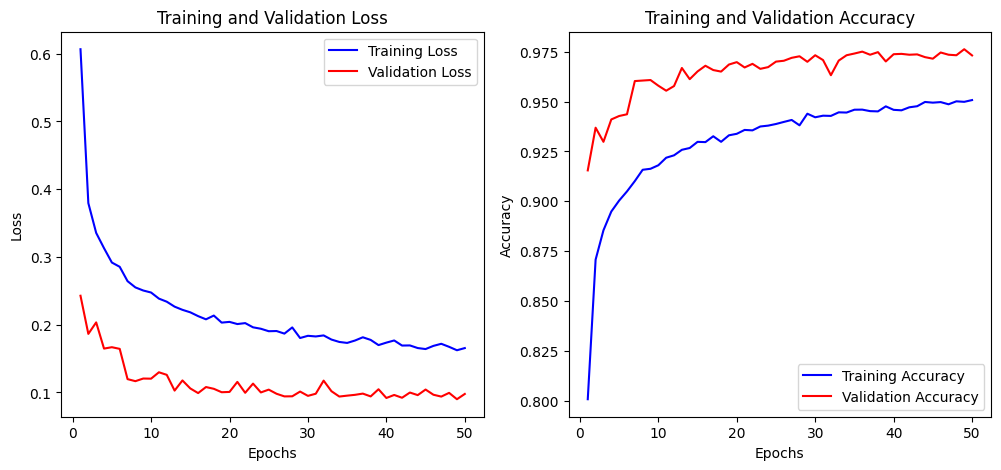

In [9]:
import matplotlib.pyplot as plt

# Plot training metrics
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'b-', label='Training Loss')
plt.plot(epochs, val_loss_values, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy_values, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()